# 0. Import libraries

The libraries used to create the data are in the following cell

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pandas as pd

# 1. Define constants

This section defines constants to be used in the notebook

In [2]:
# Path constants
DATA_FOLDER_PATH = "/Data"
DATA_FILENAME = "surfaces.csv"

# Verbosity constants
ERROR = 1
WARNING = 2

VERBOSITY_DICT = {1: "ERROR",
                  2: "WARNING"}

# Zernike polynomials indexes
ZERNIKE_POLYNOMIALS_INDEXES = [
    ( 0, 0),
    (-1, 1),
    ( 1, 1),
    (-2, 2),
    ( 0, 2),
    ( 2, 2),
    (-3, 3),
    (-1, 3),
    ( 1, 3),
    ( 3, 3)
]

COEFFICIENT_MIN = -10
COEFFICIENT_MAX = 10

# 2. Compile functions

This section has all the necessary functions to create the surfaces based on the Zernike polynomials

In [15]:
def compute_zernike_polynomial_at_point(m_index,
                                        n_index,
                                        rho,
                                        varphi,
                                        verbose=False):
    """
    This function computes the value of a Zernike polynomial on polar coordinates given the Zernike coefficients
    
    Input:
        m_index (int): The m number of the Zernike Polynomial
        n_index (int): The n number of the Zernike Polynomial
        rho (float): The distance of the point to the center (radius in polar coordinates) 
        varphi (float): The angle of the point with respect to x-axis (angle in polar coordinates)
        
    Returns:
        zernike_value (float): The value of the zernike_polynomial at the point
    """
    
    # First check if the zernike parameters are valid
    if not check_zernike_parameters(m_index, 
                                  n_index, 
                                  rho, 
                                  verbose):
        return False, None
    
    # Obtain the absolute value of the m index
    m_abs_index = abs(m_index)
    
    # Obtain the sign of the m index
    m_sign = 1
    if m_abs_index > 0:
        m_sign = m_index // m_abs_index
    
    # Compute the radial polynomial value at rho
    r_value = compute_radial_value(m_abs_index, 
                                   n_index, 
                                   rho,
                                   verbose)
    
    # Compute the zernike value
    if m_sign == 1:
        zernike_value = r_value * math.cos(m_abs_index * varphi)
    else:
        zernike_value = r_value * math.sin(m_abs_index * varphi)
        
    return zernike_value


def compute_radial_value(m_index,
                         n_index,
                         rho, 
                         verbose=False):
    """
    Computes the radial polynomial at ro given m and n indexes of the Zernike Polynomials
    
    Input:
        m_index (int): The m number of the Zernike Polynomial
        n_index (int): The n number of the Zernike Polynomial
        rho (float): The distance of the point to the center (radius in polar coordinates)
        
    Returns:
        r_value(float): The value of the radial polynomial at rho
    """
    
    # Default value of the polynomial
    if rho == 1:
        return 1
    
    # Value if n-m is odd
    r_value = 0
    
    
    n_minus_m = n_index - m_index
    module = n_minus_m % 2
    
    # If the module of n-m is even calculate
    if module == 0:
        # Compute the index of the sumatory and add 1 for the loop
        sumatory_index = (n_minus_m)//2 + 1
        
        # The summatory
        for k in range(0, sumatory_index):
            
            # Compute the numerator: (-1)^k * (n-k)!
            numerator = (-1)**k * math.factorial(n_index-k)
            
            # Compute the numbers from which we will compute their factorials for the denominator
            n_plus_m_d2_minus_k = (n_index + m_index)//2 - k  # (n+m)/2 - k
            n_minus_m_d2_minus_k = (n_index - m_index)//2 - k # (n-m)/2 - k
            
            # Compute denominator: k! * ((n+m)/2 - k)! *((n-m)/2 - k)!
            denominator = math.factorial(k) * math.factorial(n_plus_m_d2_minus_k) * math.factorial(n_minus_m_d2_minus_k)
            
            # Update the total sum
            r_value += numerator/denominator * rho**(n_index-2*k)
        
    return r_value
            
        
def check_zernike_parameters(m_index, 
                             n_index, 
                             rho, 
                             verbose=False):
    """
    This function checks that the zernike parameters are valid
    
    Input:
        m_index (int): The m number of the Zernike Polynomial
        n_index (int): The n number of the Zernike Polynomial
        rho (float): The distance of the point to the center (radius in polar coordinates) 
        verbose (bool): Indicates if the errors are displayed in console. Default is False.
    
    Returns:
        bool: True if the parameters are correct, False otherwise
    """
    
    # If n is lower than m there is an error
    if n_index < abs(m_index):
        if verbose:
            msg = f"The n index is smaller than m index: {n_index} < {abs(m_index)}"
            print_verbose_msg(msg, ERROR)
        return False
    
    # If the radius is less than 0 or greater than 1 there is an error
    if rho < 0 or rho > 1:
        if verbose:
            msg = f"The radius (ro) must be between -1 and 1. Radius is {rho}"
            print_verbose_msg(msg, ERROR)
        return False
    
    return True


def polar_samples_unit_circle_for_data_generation(n_circles=5, 
                                                  n_samples=20):
    """
    This function samples radiuses and angles from the unit disk to create random surfaces
    
    Input:
        n_circles (int): Optional. The number of concentric circles where the points will be sampled from
        n_samples (int): Optional. The number of samples of the outer circle of radius one. For the rest the number
                        of samples is proportional to the radius.
                        
    Returns:
        rho_samples (np.array): The array containing the radius polar coordinates of the points
        varphi_samples (np.array): The array containing the angle polar coordinates of the points
    """
    
    # Create empty arrays for the samples
    rho_samples = np.empty([0])
    varphi_samples = np.empty([0])
    
    # Sample points from each concentric circle
    for i in range(1, n_circles+1):
        # Each circle has a number of sample proportional to its radius
        n_subsamples = round((1 - (n_circles - i)/n_circles) * n_samples)
        
        # Sample radius and angles (radius is always the same)
        i_radiuses = np.full((n_subsamples,), i/n_circles)
        i_thetas = np.arange(0, 2* np.pi, 2* np.pi/n_subsamples)
        
        # Append the circle samples to the global samples
        rho_samples = np.concatenate((rho_samples, i_radiuses))
        varphi_samples = np.concatenate((varphi_samples, i_thetas))
    
    return rho_samples, varphi_samples


def polar_samples_unit_circle_for_plotting(n_radiuses=50, 
                                           n_angles=50):
    """
    This function samples radiuses and angles from the unit disk
    
    Input:
        n_radiuses (int): Optional. The number of radiuses to create the mesh
        n_samples (int): Optional. The number of angles to create the mesh
                        
    Returns:
        rho_samples (np.array): The array containing the radius polar coordinates of the points
        varphi_samples (np.array): The array containing the angle polar coordinates of the points
    """
    
    # Create two arrays with equidistant points
    rho_samples = np.linspace(0, 1, n_radiuses)
    varphi_samples = np.linspace(0, 2*np.pi, n_angles)
    return rho_samples, varphi_samples


def plot_2d_polar_points(rho_samples, 
                         varphi_samples):
    """
    Plots a 2d graphic with points given radiuses and thetas
    
    Input:
        rho_samples (np.array): The array containing the radius polar coordinates of the points
        varphi_samples (np.array): The array containing the angle polar coordinates of the points
    
    Returns:
        None
    """
    
    # Create a plot with polar coordinates
    fig, ax = plt.subplots(subplot_kw={'projection':'polar'})
    
    # Remove radius ticks
    ax.set_rticks([])
    
    angles = [0, 45, 90, 135, 180, 225, 270, 315]
    labels = ['0',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',\
    r'$\pi$',r'$\frac{5\pi}{4}$',r'$\frac{3\pi}{2}$',r'$\frac{7\pi}{4}$']
    ax.set_thetagrids(angles, labels=labels)
    # Plot the points
    ax.plot(varphi_samples, rho_samples, 'k.')


def print_verbose_msg(msg, 
                      level):
    """
    This function prints a message and its level of severity
    
    Input:
        msg (string): The message to display
        level (int): The dictionary key that contains the level of severity
    
    Returns:
        None
    """
    
    complete_msg = f"{VERBOSITY_DICT[level]}: {msg}"
    print(complete_msg)
    

def compute_zernike_polynomial_for_meshgrid(m_index,
                                            n_index, 
                                            rho_mesh,
                                            varphi_mesh,
                                            verbose=False):
    """
    Function to compute the zernike polynomials z component for plotting
    
    Input:
        m_index (int): The m number of the Zernike Polynomial
        n_index (int): The n number of the Zernike Polynomial
        rho_mesh (np.array): A 2d array containing the radius of the points' polar coordinates
        varphi_mesh(np.array): A 2d array containing the angle of the points' polar coordinates
        verbose (bool): Optional. True if more verbosity for errors
        
    Returns:
        zernike_mesh: The values of the zernike polynomial in the mesh grid
    """
    
    # Get rows and columns from mesh to create the Z axis matrix mesh
    rows = rho_mesh.shape[0]
    columns = rho_mesh.shape[1]
    
    # Create an empty 2d array
    zernike_mesh = np.empty((rows, columns))
    
    # Fill the Z data array with the zernike values of the points
    for r in range(0, rows):
        for c in range(0, columns):
            # Get rho and varphi from the meshes
            rho = rho_mesh[r][c]
            varphi = varphi_mesh[r][c]
            
            # Assign the result in the Z axis matrix mesh
            zernike_mesh[r][c] = compute_zernike_polynomial_at_point(m_index,
                                                                     n_index,
                                                                     rho,
                                                                     varphi,
                                                                     verbose=verbose)
            
    return zernike_mesh


def plot_surface(zernike_polynomials,
                 n_radiuses=50,
                 n_angles=50,
                 verbose=False):
    """
    Plots a surface give the zernike polynomials and its coefficients
    
    Input:
        zernike_polynomials (list): A list of tuples with polynomials info (m_index, n_index, coefficient)
        n_radiuses (int): Optional. The number of radiuses to create the mesh
        n_angles (int): Optional. The number of angles to create the mesh
        
    Returns:
        None
    """
    
    # Get the radius and angle samples
    rho_samples, varphi_samples = polar_samples_unit_circle_for_plotting(n_radiuses=n_radiuses,
                                                                         n_angles=n_angles)
    # Create the mesh grid from the sampled data
    rho_mesh, varphi_mesh = np.meshgrid(rho_samples, varphi_samples)
    
    # Create a list with the zernike meshes
    zernike_meshes = []
    
    # Calculate each the zernike mesh
    for m_index, n_index, coefficient in zernike_polynomials:
        z_mesh = compute_zernike_polynomial_for_meshgrid(m_index,
                                                         n_index,
                                                         rho_mesh,
                                                         varphi_mesh,
                                                         verbose=verbose)
        # Weight the zernike mesh with its coefficient
        weighted_z_mesh = coefficient * z_mesh
        
        # Add the weighted zernike mesh to the meshes list
        zernike_meshes.append(weighted_z_mesh)
    
    # Get the shape of the zernike matrix mesh
    rows = rho_mesh.shape[0]
    columns = rho_mesh.shape[1]
    
    # Create an empty surface mesh
    surface_mesh = np.zeros((rows, columns))
    
    # Combine all the zernike meshes
    for submesh in zernike_meshes:
        surface_mesh += submesh
        
    # Converto to cartesian coordinates
    X, Y = rho_mesh*np.cos(varphi_mesh), rho_mesh*np.sin(varphi_mesh)
    
    # Create figure
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    # Plot the surface
    ax.plot_surface(X, Y, surface_mesh, cmap=plt.cm.YlGnBu_r)
    plt.show()

    
def get_random_zernike_coefficients():
    """
    Describes a random surface based on the zernike polynomials returning their indexes and coefficients to plot them
    Input:
        None
    
    Returns:
        zernike_polynomials (list): A list of tuples with zernike polynomials info (m_index, n_index, coefficient)
    """
    
    zernike_polynomials = []
    
    # Create the zernike tuples containing m index, n index and coefficient of the polynomial
    for zpi in ZERNIKE_POLYNOMIALS_INDEXES:
        # Get a random coefficient for the zernike polynomial
        coef = random.uniform(COEFFICIENT_MIN, COEFFICIENT_MAX)
        # Create the combined tuple
        zp = zpi + (coef,)
        # Append it to the list of zernike polynomials with coefficients
        zernike_polynomials.append(zp)

    return zernike_polynomials


def sample_random_surface(rho_coordinates,
                          varphi_coordinates,
                          zernike_polynomials,
                          verbose=False):
    """
    Samples the z value of a surface given its zernike polynomials and polar coordinates of points
    
    Input:
        rho_coordinates (np.array): The array containing the radius polar coordinates of the points
        varphi_coordinates (np.array): The array containing the angle polar coordinates of the points
        zernike_polynomials (list): A list of tuples with zernike polynomials info (m_index, n_index, coefficient)
        verbose (bool): Optional. True if more verbosity for errors
        
    Returns:
        z_values (np.array): The array containing the z value of the surface in the coordinates
    """
    
    # The list to store the z values
    z_list = []
    
    # Loop to compute the z value on all the given points
    for (rho, varphi) in zip(rho_coordinates, varphi_coordinates):
        z_value = compute_surface_value_at_point(rho,
                                                 varphi,
                                                 zernike_polynomials,
                                                 verbose=verbose)
        z_list.append(z_value)
    
    # Convert list to numpy array
    z_values = np.array(z_list)
    
    return z_values
        

def compute_surface_value_at_point(rho,
                                   varphi,
                                   zernike_polynomials,
                                   verbose=False):
    """
    Function to compute the z value of a surface at a point given zernike coefficients and polar coordinates of point
    
    Input:
        rho (float): The distance of the point to the center (radius in polar coordinates) 
        varphi(float): The angle of the point with respect to x-axis (angle in polar coordinates)
        zernike_polynomials (list): A list of tuples with zernike polynomials info (m_index, n_index, coefficient)
        verbose (bool): Optional. True if more verbosity for errors
        
    Returns:
        z_value (float): The value of the surface at the point
    """
    
    # Initialize the z value of the point
    z_value = 0
    
    # For compute the point value on each zernike polynomials and add them all with a weighted sum
    for m_index, n_index, coefficient in zernike_polynomials:
        actual_value = compute_zernike_polynomial_at_point(m_index,
                                                           n_index,
                                                           rho,
                                                           varphi,
                                                           verbose=verbose)
        weighted_value = coefficient * actual_value
        z_value += weighted_value
        
    return z_value


def generate_data_for_training(n_data,
                               verbose=False):
    """
    Generates a dataframe with data for training
    
    Input:
        n_data (int): Number of data points to train (A data point consisting on a surface and its zernike coefficients)
        verbose (bool): Optional. True if more verbosity for errors
        
    Returns:
        surface_dataframe (pd.DataFrame): A dataframe with columns 'surface_values' and 'zernike_coefficients' contaning arrays
    """
    
    surface_list = []
    coefficient_list = []
    
    for i in range(0, n_data):
        # Get the zernike polynomials with their coefficients
        zernike_polynomials = get_random_zernike_coefficients()
        
        # Get the points polar coordinates to sample from the surface created by the zernike polynomials
        rho_coordinates, varphi_coordinates = polar_samples_unit_circle_for_data_generation()
        
        # Compute the values of the surface at the points
        surface_values = sample_random_surface(rho_coordinates,
                                               varphi_coordinates,
                                               zernike_polynomials,
                                               verbose=verbose)
        
        # Append the surface values to the surface list
        surface_list.append(surface_values)
        
        # Get last element (zernike coefficient) of the zernike polynomials tuples to store them in the dataframe
        coefficients = list(map(lambda x: x[-1], zernike_polynomials))
        
        # Convert the list to a numpy array
        np_coefficients = np.array(coefficients)
        
        # Append the surface zernike coefficients to the list of coefficients
        coefficient_list.append(np_coefficients)
    
    # Create a dictionary with the data generated
    data = {
        'surface_points': surface_list,
        'zernike_coefficients': coefficient_list
    }
    # Create the dataframe from the data dictionary
    surface_dataframe = pd.DataFrame(data)
    
    return surface_dataframe

# 3. The process of generating data

We will be generating random surfaces using the basis of zernike polynomials.

In the first place we will sample point from the unit disk in polar coordinates

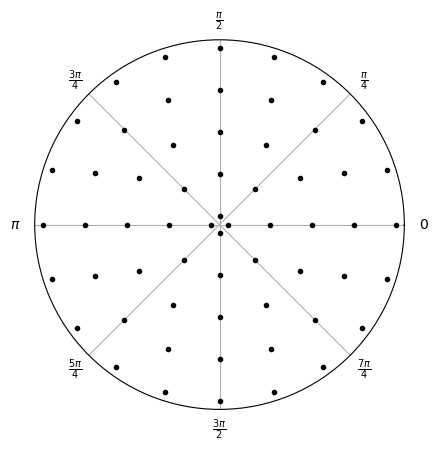

In [16]:
rho_array, varphi_array = polar_samples_unit_circle_for_data_generation()
plot_2d_polar_points(rho_array, varphi_array)

Then we will get random zernike coefficients for each polynomial that describe a random surface

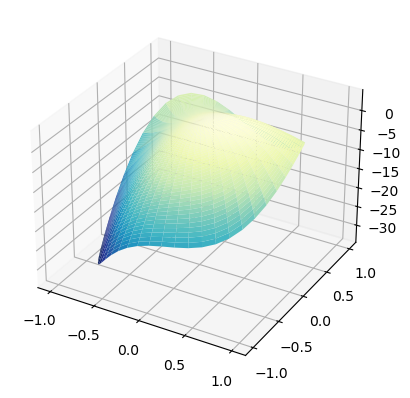

In [17]:
zernike_polynomials = get_random_zernike_coefficients()
plot_surface(zernike_polynomials)

We will repeat this process a number of times and store the z values of the surface and its zernike coefficients in a pandas dataframe

In [19]:
n_surfaces = 3
dataframe = generate_data_for_training(n_surfaces,
                                       verbose=True)
dataframe

,surface_points,zernike_coefficients
0,"[-0.9386482443398521, -0.7446227051304656, -3....","[-4.443352640673551, 2.809416592228187, -8.546..."
1,"[6.424593261318267, 2.8858831351122385, 0.8837...","[7.653091797949056, -1.9385645494519181, 8.488..."
2,"[15.70020317354948, 12.403166048617697, 11.723...","[7.2656262324764285, -2.651506635385241, 0.771..."


# 4. Data genation

We will create 60.000 data points

In [ ]:
n_surfaces = 60.000
surfaces_dataframe = generate_data_for_training(n_surfaces,
                                                verbose=True)

